# CarND Advanced Lane Lines Project

In this notebook Advanced Lane Lines detection pipeline is created. On a high level pipeline contains:
1. Caliberate camera using caliberation images provided & calculate the distortion matrix.
2. Undistort the image using the distortions matrix.
3. Perspective Transform the image for better detection of lane line & curvature.
4. Apply sobel & S channel filter. Obtain combined image.
5. Obtain Histogram of image in slice.
6. Smooth the histograms and extract local maximum points.
7. If with two maximas fit them in a polygon.
8. Calculate curvature.
9. Filter polynomials if curvatures do not match.
10. Invert & project lanes to original image space.

## 1. Basic import

In [1]:
import cv2

import glob

from IPython.display import HTML

import imageio

import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip

import numpy as np

from PIL import Image

import pickle

import random

from scipy import signal
import scipy.misc
from scipy.spatial import distance
from scipy.signal import find_peaks_cwt
from scipy.signal import argrelextrema

## 2. Load caliberation images

Caliberation Images imported


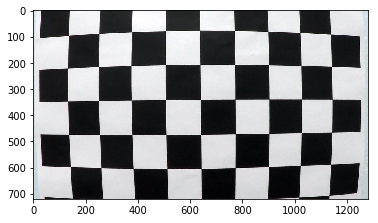

In [2]:
%matplotlib inline

nx = 9
ny = 6

image_list = []
for filename in glob.glob('camera_cal/*.jpg'):
    image_list.append(cv2.imread(filename))
    
print('Caliberation Images imported')
plt.imshow(image_list[0])

## 3. Caliberate camera & Generate Co-efficients for caliberation.

1. Convert the images to grayscale. 
2. Apply the findChessboardCorners to get all corners. 
3. Call calibrateCamera method of opencv to get the camera cliberation matrix and coefficients.

In [3]:
objpoints = []
imgpoints = []
    
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
for image in image_list:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera( objpoints, 
                                                        imgpoints, 
                                                        gray.shape[::-1], 
                                                        None, 
                                                        None)

print('Camera Caliberated')

Camera Caliberated


## 4. Define Undistort

In [4]:
def undistort(img):
    img_undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, camera_matrix)
    return img_undistorted

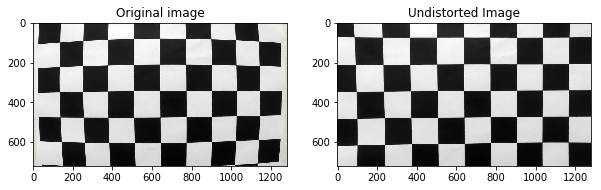

In [5]:
image = cv2.cvtColor(image_list[0], cv2.COLOR_BGR2RGB)
gs = gridspec.GridSpec(1, 2, width_ratios=[30, 30]) 

f = plt.figure(figsize=(10, 8))
f1 = plt.subplot(gs[0])
f1.imshow(image)
f1.set_title('Original image')

f2 = plt.subplot(gs[1])
f2.imshow(undistort(image))
f2.set_title('Undistorted Image')

Test Undistort on a test image.

Done!


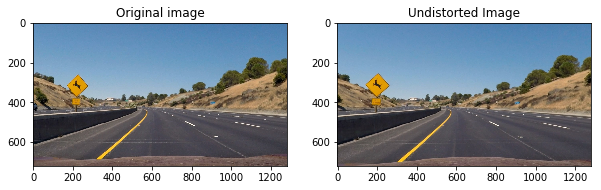

In [6]:
image = cv2.imread('./test_images/test2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gs = gridspec.GridSpec(1, 2, width_ratios=[30, 30]) 

f = plt.figure(figsize=(10, 8))
f1 = plt.subplot(gs[0])
f1.imshow(image)
f1.set_title('Original image')

f2 = plt.subplot(gs[1])
f2.imshow(undistort(image))
f2.set_title('Undistorted Image')

print('Done!')

## 4. Pipeline

### 1. Sobelx

In [7]:
def apply_sobel_x(image, thresh_min=20, thresh_max=200):
    # Sobel x
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Apply a threshold
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary

### 2. S channel threshold

In [8]:
def apply_hls_threshold(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #plt.imshow(s_channel)
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= 130) & (s_channel <= 240)) | ((l_channel >= 220) & (l_channel <= 255))] = 1
    #print(s_binary)

    return s_binary

### 3. Color Selection

In [9]:
def get_color_selection(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    lower_yellow = np.array([0, 90, 90], dtype=np.uint8)
    upper_yellow = np.array([210,250,255], dtype=np.uint8)
    
    lower_white =np.array([170,170,170], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    
    # Get the white pixels from the original image
    mask_white = cv2.inRange(image, lower_white, upper_white)

    # Get the yellow pixels from the HSV image
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # Bitwise-OR white and yellow mask
    mask = cv2.bitwise_or(mask_white, mask_yellow)
    return mask

### 4. Combine Thresholds

In [10]:
def threshold_image(image):

    binary_sobel = apply_sobel_x(image)
    binary_hls = apply_hls_threshold(image)
    binary_rbg = get_color_selection(image)
    
    # Combine all thresholds and filters
    combined_binary = np.zeros_like(binary_sobel)
    combined_binary[((binary_sobel == 1) & (binary_hls == 1)) | (binary_rbg > 0) ] = 1
    
    return combined_binary

### 5. Utility method to merge images

In [11]:
def merge_images(img1, img2):
    return cv2.addWeighted(img1, 0.4, img2, 0.6, 0)

### 6. Test pipeline on test image

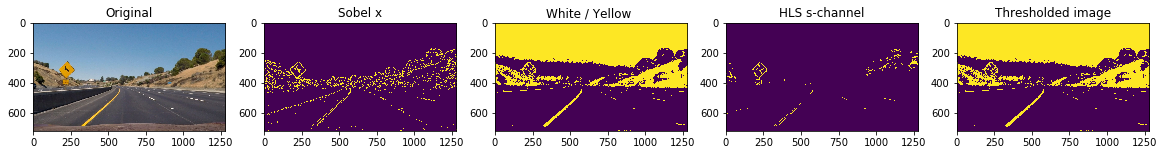

In [12]:
gs = gridspec.GridSpec(1, 5, width_ratios=[30, 30, 30, 30, 30]) 
filtered = threshold_image(image)
                           
f = plt.figure(figsize=(20, 20))
f0 = plt.subplot(gs[0])
f0.imshow(image)
f0.set_title('Original')

f1 = plt.subplot(gs[1])
f1.imshow(apply_sobel_x(image))
f1.set_title('Sobel x')

f2 = plt.subplot(gs[2])
f2.imshow(get_color_selection(image))
f2.set_title('White / Yellow ')

f3 = plt.subplot(gs[3])
f3.imshow(apply_hls_threshold(image))
f3.set_title('HLS s-channel')

f4 = plt.subplot(gs[4])
f4.imshow(filtered)
f4.set_title('Thresholded image')

Output imgaes clearly show that combined image preserves all the details of lane lines. Pipeline is good enough to proceed further.

### 7. Perspective Transform to pipeline

Going through the test images came up with polygon for source & rectangle for destination for perspective transformation.

In [13]:
image = undistort(image)
h = image.shape[0]

src_mat = [
    [230,695],
    [578,458],
    [704,458],
    [1065,695]
]

dst_mat = [
    [220,h],
    [220,0],
    [1060,0],
    [1060,h]
]

Plotting the point on a test image.

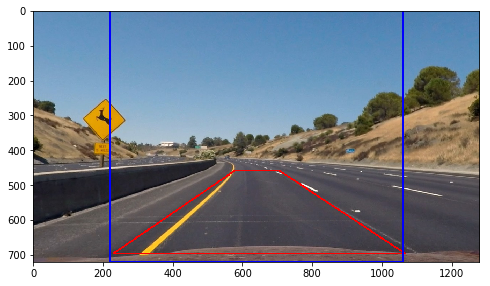

In [14]:
height, width = image.shape[0], image.shape[0]
vertices = np.array([[(0+100, height), (width/2-20, height/2+50),
                    (width/2+20, height/2+50), (width-50, height)]], 
                    dtype=np.int32)


src = np.int32(src_mat)

dst = np.int32(dst_mat)

lanes_marked = np.copy(image)
lanes_marked = cv2.polylines(lanes_marked,[src],True,(255,0,0), thickness=3)
lanes_marked = cv2.polylines(lanes_marked,[dst],True,(0,0,255), thickness=3)

plt.figure(figsize=(8,8))
plt.imshow(lanes_marked)

#### Perspective Transform

In [15]:
def transform(image):
    
    h = image.shape[0]
    w = image.shape[1]
    src = np.float32(src_mat)
    dst = np.float32(dst_mat) 

    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(image, M, (w,h))
    return warped

def inverse_transform(image):
    
    h = image.shape[0]
    w = image.shape[1]
    src = np.float32(src_mat)
    dst = np.float32(dst_mat) 

    M = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(image, M, (w,h))
    empty = np.zeros(warped.shape, dtype=np.uint8)
    final = np.dstack((warped, empty, empty))
    return final

#### Test Trasformation

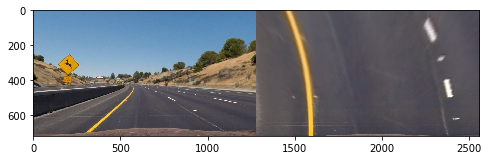

In [16]:
transformed_image = transform(image)
plt.figure(figsize=(8,8))
plot_image = np.concatenate((image, transformed_image),axis=1) 
plt.imshow(plot_image)

### 8. Curvature Calculation

In [17]:
ym_per_pixel = 30/720 # meters per pixel in y dimension
xm_per_pixel = 3.7/700 # meters per pixel in x dimension

In [18]:
def calculate_curvature(line) :
    return ((ym_per_pixel**2 + xm_per_pixel**2*(2*line[0]*720 + line[1])**2)**1.5)/(2*xm_per_pixel*ym_per_pixel*line[0])

Distance to lanes

In [19]:
def calculate_distance_to_lanes(left_lane, right_lane) :
    border_left = calculate_distance_to_lane(left_lane)
    border_right = calculate_distance_to_lane(right_lane)
    middle = (border_left + border_right) / 2.0
    diff_in_pixels = 1280/2 - middle
    diff_in_m = diff_in_pixels * xm_per_pixel
    return diff_in_m

def calculate_distance_to_lane(line) :
    y = 720
    dist = line[0]*y*y + line[1]*y + line[2]
    return dist

### 9. Lane Points

To identify lane pixels apply following steps.

1. Load a thresholded image 
2. Define verticle slices.
3. For each vertical slice
    * Create a histogram.
    * Smooth the histogram with a generalized Gaussian shape (method: signal.general_gaussian)
    * Calculate the relative extrema of data (method: argrelextrema)
    * Split extremas to left and right lanes based on their x value
    * If only one extrema is found on each side store them for later processing
    * If two are found, check if they are close (distance < threshold)
    * If they are close store their average for later processing
    * In other cases, ignore the points for this slice

In [20]:
def find_lane_points(image, visualize = False):
    height = image.shape[0]
    width = image.shape[1]
    window_size = 40
    left_lanes_x = []
    left_lanes_y = []
    right_lanes_x = []
    right_lanes_y = []
    
    
    gs = gridspec.GridSpec(int(height / window_size),1)
    if visualize:
        fig = plt.figure()

    # Verticle Slices
    for window_index in range(1,int(height / window_size)):
        window_lanes = image[window_index*window_size:(window_index+1)*window_size, :]
        # Create a histogram.                   
        histogram = np.sum(window_lanes, axis=0)
        # Smooth the histogram with a generalized Gaussian shape
        window = signal.general_gaussian(49, p=3, sig=40)
        filtered = signal.fftconvolve(window, histogram)
        filtered = (np.average(histogram) / np.average(filtered)) * filtered
        histogram = np.roll(filtered, -25)

        if visualize:
            ax = fig.add_subplot(gs[window_index])
            ax.plot(histogram)
        # Calculate the relative extrema of data    
        indices = argrelextrema(histogram, np.greater)
        # Split extremas to left and right lanes based on their x value
        data_y_left = []
        data_x_left = []
        data_y_right = []
        data_x_right = []
        
        for i in indices[0]:
            if histogram[i] > 8:
                if i > 600:
                    data_x_right.append(i)
                    data_y_right.append(window_size*window_index)
                else:
                    data_x_left.append(i)
                    data_y_left.append(window_size*window_index)
        # If only one extrema is found on each side store them for later processing
        if len(data_x_left) == 1:
            left_lanes_x.append(data_x_left[0])
            left_lanes_y.append(data_y_left[0])
        if len(data_x_left) == 2:
            # If two are found, check if they are close 
            if distance.euclidean((data_x_left[0], data_y_left[0]),(data_x_left[1], data_y_left[1])) < 34:
                left_lanes_x.append(int((data_x_left[0]+data_x_left[1]) / 2))
                left_lanes_y.append(int((data_y_left[0]+data_y_left[1]) / 2))
        # If only one extrema is found on each side store them for later processing
        if len(data_x_right) == 1:
            right_lanes_x.append(data_x_right[0])
            right_lanes_y.append(data_y_right[0])
        if len(data_x_right) == 2:
            # If two are found, check if they are close 
            if distance.euclidean((data_x_right[0], data_y_right[0]),(data_x_right[1], data_y_right[1])) < 34:
                right_lanes_x.append(int((data_x_right[0]+data_x_right[1]) / 2))
                right_lanes_y.append(int((data_y_right[0]+data_y_right[1]) / 2))

    if visualize:
        plt.show()
        
    return left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y

Visualize the Lane Points

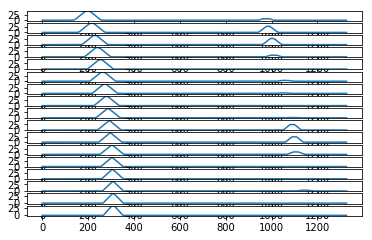

In [21]:
thresholded_image = threshold_image(transformed_image)

left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y = find_lane_points(thresholded_image, True)

Plot lane points points

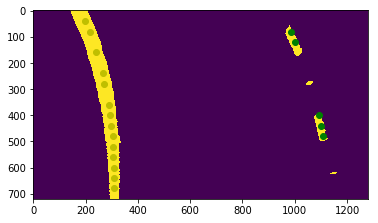

In [22]:
plt.plot(right_lanes_x, right_lanes_y, 'og')
plt.plot(left_lanes_x, left_lanes_y, 'oy')

plt.imshow(thresholded_image)

### 10. Plot Lane Lines

Find lane lines to fit polylines, export their detected points and return a layered image with left and right curvature

In [23]:
def find_lines(image, left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y):
    if len(left_lanes_x) < 3:
        return False, 0, 0, 0, 0, 0
    if len(right_lanes_x) < 3:
        return False, 0, 0, 0, 0, 0
    
    overlay_lanes = np.copy(image)
    left_line = np.polyfit(left_lanes_y, left_lanes_x, deg=2)
    p = np.poly1d(left_line)
    x = list(range(0, image.shape[0]))
    y = list(map(int, p(x)))
    line1_pts = np.array([[_y,_x] for _x, _y in zip(x, y)])
    line1_pts = line1_pts.reshape((-1,1,2))
    cv2.polylines(overlay_lanes, np.int32([line1_pts]), False, color=(255,0,0), thickness=50)
    left_r = calculate_curvature(left_line)
    
    right_line = np.polyfit(right_lanes_y, right_lanes_x, deg=2)
    p = np.poly1d(right_line)
    x = list(range(0, image.shape[0]))
    y = list(map(int, p(x)))
    line2_pts = np.array([[_y,_x] for _x, _y in zip(x, y)])
    line2_pts = line2_pts.reshape((-1,1,2))
    cv2.polylines(overlay_lanes, np.int32([line2_pts]), False, color=(255,0,0), thickness=50)
    right_r = calculate_curvature(right_line)

    top_points = [line1_pts[-1], line2_pts[-1]]
    base_points = [line1_pts[0], line2_pts[0]]
    
    # Fill in the detected lane
    cv2.fillPoly(overlay_lanes, [np.concatenate((line2_pts, line1_pts, top_points, base_points))], color=(100,200,150))
    return True, overlay_lanes, left_r, right_r, left_line, right_line

Test Finding Lines & Overlay

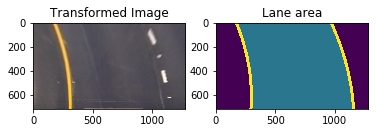

In [24]:
success, overlay_lanes, left_r, right_r, l1, l2 = find_lines(thresholded_image, left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y)

if success == False:
    print('success = ' + str(success))
    print('Failed to extract lanes')
else:
    f, (f1, f2) = plt.subplots(1, 2)
    f1.imshow(transform(image))
    f1.set_title('Transformed Image')
    f2.imshow(overlay_lanes)
    f2.set_title('Lane area')

Inverse Transform the image & merge.

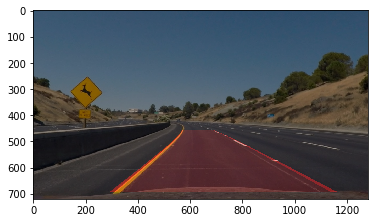

In [25]:
final = inverse_transform(overlay_lanes)
final_merged = merge_images(final, image)
plt.imshow(final_merged)

## 5. Using the pipeline on Video

We can see that the above definition of finding lane lines can lead to failure in cases of certain frames. But we can take advantage of lane lines detected in previous frames to smoothen the lane lines. In this approach, the previous lane points are not moved "backwards" due to the car motion but considered on the same frame as the current lane points. Looking back to just one frame is limited here to 1.

In [26]:
history_size = 1

In [27]:
def history(history, current):
    size = len(history)
    if size < history_size:
        return current
    if history_size == 1:
        return current
    output = current
    for i in range(1, history_size + 1):
        output = output + history[size - i]
    return output

In [28]:
history_left_x, history_left_y, history_right_x, history_right_y = [],[],[],[]
old_distance_to_center = 0
old_lanes_image = []
i = 0

def process(image, useHistory = True):
    global old_lanes_image
    global old_distance_to_center
    
    undistorted = undistort(image)
    
    projected = transform(undistorted)
    
    lanes_image = threshold_image(projected)
    
    left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y = find_lane_points(lanes_image)
    
    history_left_x.append(left_lanes_x)
    history_left_y.append(left_lanes_y)
    history_right_x.append(right_lanes_x)
    history_right_y.append(right_lanes_y)
    
    history_length = len(history_left_x)

    left_x = history(history_left_x, left_lanes_x)
    left_y = history(history_left_y, left_lanes_y)
    right_x = history(history_right_x, right_lanes_x)
    right_y = history(history_right_y, right_lanes_y)
    success, overlay_lanes, left_r, right_r, left, right = find_lines(lanes_image, left_x, left_y, right_x, right_y)

    # If pipeline fails then use old distance.
    if success == False:
        distance_to_center = old_distance_to_center
    else:
        distance_to_center = round(calculate_distance_to_lanes(left, right),2)
    
    if len(old_lanes_image) == 0:
        old_lanes_image = overlay_lanes
        
    if success == False:
        overlay_lanes = old_lanes_image
    if abs(left_r) < 280 or abs(right_r) < 280:
        overlay_lanes = old_lanes_image

    if left_r * right_r < 0:
        if abs(abs(left_r) - abs(right_r)) >2000 and (abs(left_r) < 1000 or abs(right_r) < 1000):
            overlay_lanes = old_lanes_image
        
    final = inverse_transform(overlay_lanes)
    final_merged = merge_images(final, image)
    
    old_lanes_image = overlay_lanes
    
    global i
    if distance_to_center > 0: 
        distance_to_center_desc = "right"
    else :
        distance_to_center_desc = "left"
    # Annotate the image
    cv2.putText(final_merged, 'Left lane curvature: '+str(round(abs(left_r),2))+' Right Lane curvature: '+str(round(abs(right_r),2)), (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 100), 2)
    cv2.putText(final_merged, 'Car position: '+str(abs(distance_to_center))+' meters on the '+distance_to_center_desc+' from the center of the lane', (50, 160), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 100), 2)
    
    i = i + 1
    return final_merged

## 5. Run on project video

In [29]:
project_video_labeled = './project_video_labeled.mp4'
project_video = VideoFileClip("./project_video.mp4")
white_clip = project_video.fl_image(process)
%time white_clip.write_videofile(project_video_labeled, audio=False)

[MoviePy] >>>> Building video ./project_video_labeled.mp4
[MoviePy] Writing video ./project_video_labeled.mp4


100%|█████████▉| 1260/1261 [02:23<00:00,  8.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_labeled.mp4 

CPU times: user 3min 39s, sys: 22.3 s, total: 4min 1s
Wall time: 2min 24s


#### Output of project Video

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_labeled))

#### Summary

In project video the lane area is properly labeled. At all times the Lane is properly visible. Label shows 'Left' & 'Right' Curvature properly. Car position from the lane centre is displayed.

## 6. Run on Challenge Video

In [31]:
challenge_labeled_video = './challenge_labeled_video.mp4'
challenge_video = VideoFileClip("./challenge_video.mp4")
white_clip = challenge_video.fl_image(process)
%time white_clip.write_videofile(challenge_labeled_video, audio=False)

[MoviePy] >>>> Building video ./challenge_labeled_video.mp4
[MoviePy] Writing video ./challenge_labeled_video.mp4


100%|██████████| 485/485 [00:47<00:00, 10.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_labeled_video.mp4 

CPU times: user 1min 12s, sys: 7.76 s, total: 1min 20s
Wall time: 48 s


#### Output of Challenge Video

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_labeled_video))

#### Summary

At all positions the Lane Area is properly annotated. At some places the curvature isn't properly detected. Overall more work in smothening is needed.

## 7. Harder Challenge Video

In [33]:
harder_challenge_labeled_video = './harder_challenge_labeled_video.mp4'
harder_challenge_video = VideoFileClip("./harder_challenge_video.mp4")
white_clip = harder_challenge_video.fl_image(process)
%time white_clip.write_videofile(harder_challenge_labeled_video, audio=False)

[MoviePy] >>>> Building video ./harder_challenge_labeled_video.mp4
[MoviePy] Writing video ./harder_challenge_labeled_video.mp4


100%|█████████▉| 1199/1200 [02:05<00:00,  8.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_labeled_video.mp4 

CPU times: user 3min 18s, sys: 23.4 s, total: 3min 42s
Wall time: 2min 6s


#### Output of Harder Challenge Video

In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_labeled_video))

#### Summary

In this video of annotation is way away. Tried experimenting with the histogram in order to detect two lines very close as one.